# Model Performance


## Prerequisites
Install python packages

In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn requests
%pip install segmentationmetrics

## Import required python packages

In [2]:
import warnings

warnings.filterwarnings("ignore")

import io
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pydicom_seg
import requests
import scipy.stats as stats
import seaborn as sns
import segmentationmetrics as sm
import SimpleITK as sitk
import skimage.measure
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline

In [3]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

# Download the segmentation results from zenodo

In [4]:
qa_dir = Path("qa-results")

In [5]:
def download_inference(
    extract_dir="qa-results", record="13244892", filename="kidney-ct.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [6]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    if label in result.available_segments:
        image = result.segment_image(label)
    else:
        # create an empty image
        tmp_img = result.segment_image(list(result.available_segments)[0])
        tmp_arr = sitk.GetArrayFromImage(tmp_img)
        image = sitk.GetImageFromArray(np.zeros_like(tmp_arr))
        image.CopyInformation(tmp_img)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    if label == 1:
        img = sitk.Cast(img >= label, sitk.sitkUInt8)
    else:
        img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(
    ai_seg_file,
    qa_seg_file,
    fname,
    label_value=1,
    version="aimiv2",
    label_suffix="",
    nsd_tol=7,
):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "normalized_surface_distance": compute_surface_dice_at_tolerance(
            m._surface_dist, nsd_tol
        ),
        "SeriesUID": fname,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
        "normalized_surface_distance_tolerance": nsd_tol,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics


def get_false_discovery(
    img_file_pred: str, img_file_gt: str, label_value: int = 1, prefix=""
):
    """Get the false discovery rate for two images, predicted (image_file_pred) and ground truth (image_file_gt)."""
    img_pred = load_seg(img_file_pred, label_value)
    img_gt = load_seg(img_file_gt, label_value)
    img_gt = resize_label(img_gt, img_pred)  # match the size of the qa_img

    vox_ml = np.prod(img_pred.GetSpacing()) / 1000

    pd_cc = sitk.GetArrayViewFromImage(sitk.ConnectedComponent(img_pred))
    gt_cc = sitk.GetArrayViewFromImage(sitk.ConnectedComponent(img_gt))

    # pd_arr = sitk.GetArrayFromImage(img_pred)
    # gt_arr = sitk.GetArrayFromImage(img_gt)
    # pd_cc = skimage.measure.label(pd_arr)
    # gt_cc = skimage.measure.label(gt_arr)
    true_pd_cc = pd_cc.copy()
    true_pd_cc[gt_cc == 0] = 0
    overlap_gt_cc = gt_cc.copy()  # gt labels that overlap with predicted
    overlap_gt_cc[pd_cc == 0] = 0

    pd_labels = np.dstack(np.unique(pd_cc, return_counts=True))[0, 1:]
    gt_labels = np.dstack(np.unique(gt_cc, return_counts=True))[0, 1:]
    true_pd_labels = np.dstack(np.unique(true_pd_cc, return_counts=True))[0, 1:]
    overlap_gt_labels = np.dstack(np.unique(overlap_gt_cc, return_counts=True))[0, 1:]

    true_vol_overlap_ml = true_pd_labels[..., 1] * vox_ml

    # get false positives
    false_pos_vols_ml = []
    for pd_label, pd_size in pd_labels:
        if pd_label not in true_pd_labels[..., 0]:
            false_pos_vols_ml.append(pd_size * vox_ml)

    # get false negatives
    false_neg_vols_ml = []
    for gt_label, gt_size in gt_labels:
        if gt_label not in overlap_gt_labels[..., 0]:
            false_neg_vols_ml.append(gt_size * vox_ml)

    stats = {
        "true_vol_overlap_ml": true_vol_overlap_ml,
        "false_pos_vols_ml": false_pos_vols_ml,
        "false_neg_vols_ml": false_neg_vols_ml,
        "true_vol_overlap_ml_total": sum(true_vol_overlap_ml),
        "false_pos_vol_ml_total": sum(false_pos_vols_ml),
        "false_neg_vol_ml_total": sum(false_neg_vols_ml),
        "true_pos_cnt": len(true_vol_overlap_ml),
        "false_pos_cnt": len(false_pos_vols_ml),
        "false_neg_cnt": len(false_neg_vols_ml),
    }
    stats["pos_cnt"] = stats["true_pos_cnt"] + stats["false_neg_cnt"]

    if prefix:
        stats = {f"{prefix}-{k}": v for k, v in stats.items()}

    return stats

In [7]:
# Load the CSV file
df = pd.read_csv(Path("qa-results/qa-results.csv"))
qa_df = df[df.Validation]

# Paths for aimiv1, aimiv2, and qa
ai_path = Path("qa-results/ai-segmentations-dcm")
qa_path = Path("qa-results/qa-segmentations-dcm")

In [8]:
# labels and tolerances
label_names = {1: "Kidney", 2: "Tumor", 3: "Cyst"}
nsd_tolerances = {1: 7, 2: 2, 3: 2}  # per label tolerances in mm

In [9]:
# verify that the labels in the dcm file match the expected labels
ds = pydicom.dcmread(ai_path / df.AISegmentation.iloc[0])
result = pydicom_seg.SegmentReader().read(ds)
label_names_from_dcm = {
    k: v["SegmentDescription"].value for k, v in result.segment_infos.items()
}
assert (
    label_names_from_dcm == label_names
), "labels in the dcm file do not match expected labels"

In [10]:
# Initialize lists for metrics
metrics = []

# Iterate over all QA cases
for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    ai_file = ai_path / row.AISegmentation
    if not pd.isna(row.CorrectedSegmentation):
        qa_file = qa_path / row.CorrectedSegmentation
    else:
        # reviewer had no corrections, use AI segmentation as QA
        qa_file = ai_file

    assert ai_file.exists(), f"AI segmentation not found for {row.AISegmentation}"
    assert qa_file.exists(), f"QA segmentation not found for {row.QASegmentation}"

    version = "aimiv1" if row.AimiProjectYear == 2023 else "aimiv2"
    for label_value in [1, 2, 3]:
        stats = calc_metrics_for_label(
            ai_file,
            qa_file,
            row.SeriesInstanceUID,
            version=version,
            label_value=label_value,
            nsd_tol=nsd_tolerances[label_value],
        )
        stats["label_name"] = label_names[label_value]
        if label_value in (2, 3):
            detection_metrics = get_false_discovery(
                ai_file, qa_file, label_value=label_value
            )
            # ignore array values
            for x in ("true_vol_overlap_ml", "false_neg_vols_ml", "false_pos_vols_ml"):
                detection_metrics.pop(x)
            stats.update(detection_metrics)
        metrics.append(stats)


metrics_df = pd.DataFrame(metrics)

# Replace infinite values with NaN and drop NaN values
# metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan).dropna()

100%|██████████| 85/85 [04:49<00:00,  3.41s/it]


In [20]:
aggregated_df = (
    metrics_df.groupby(["label_name", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "normalized_surface_distance": ["mean", "std"],
            "normalized_surface_distance_tolerance": "first",
            "pos_cnt": ["sum"],
            "true_pos_cnt": ["sum"],
            "false_pos_cnt": ["sum"],
            "false_neg_cnt": ["sum"],
        }
    )
    .round(2)
)
aggregated_df

dice       hausdorff_distance_95       \
                    mean   std                  mean  std   
label_name version                                          
Cyst       aimiv1   0.87  0.29                   inf  NaN   
           aimiv2   1.00  0.00                   inf  NaN   
Kidney     aimiv1   0.96  0.15                   inf  NaN   
           aimiv2   1.00  0.00                   0.0  0.0   
Tumor      aimiv1   0.91  0.27                   inf  NaN   
           aimiv2   1.00  0.00                   0.0  0.0   

                   mean_surface_distance       normalized_surface_distance  \
                                    mean   std                        mean   
label_name version                                                           
Cyst       aimiv1                   1.57  4.76                        0.89   
           aimiv2                   0.00  0.00                        1.00   
Kidney     aimiv1                   1.22  4.44                        0.96   
           aimiv2                   0.00  0.01                        1.00   
Tumor      aimiv1                   1.38  7.13                        0.90   
           aimiv2                   0.15  0.38                        1.00   

                         normalized_surface_distance_tolerance pos_cnt  \
                     std                                 first     sum   
label_name version                                                       
Cyst       aimiv1   0.26                                     2   163.0   
           aimiv2   0.00                                     2    25.0   
Kidney     aimiv1   0.14                                     7     0.0   
           aimiv2   0.00                                     7     0.0   
Tumor      aimiv1   0.27                                     2   180.0   
           aimiv2   0.00                                     2    13.0   

                   true_pos_cnt false_pos_cnt false_neg_cnt  
                            sum           sum           sum  
label_name version                                           
Cyst       aimiv1         163.0           0.0           0.0  
           aimiv2          25.0           0.0           0.0  
Kidney     aimiv1           0.0           0.0           0.0  
           aimiv2           0.0           0.0           0.0  
Tumor      aimiv1         177.0           0.0           3.0  
           aimiv2          13.0           0.0           0.0

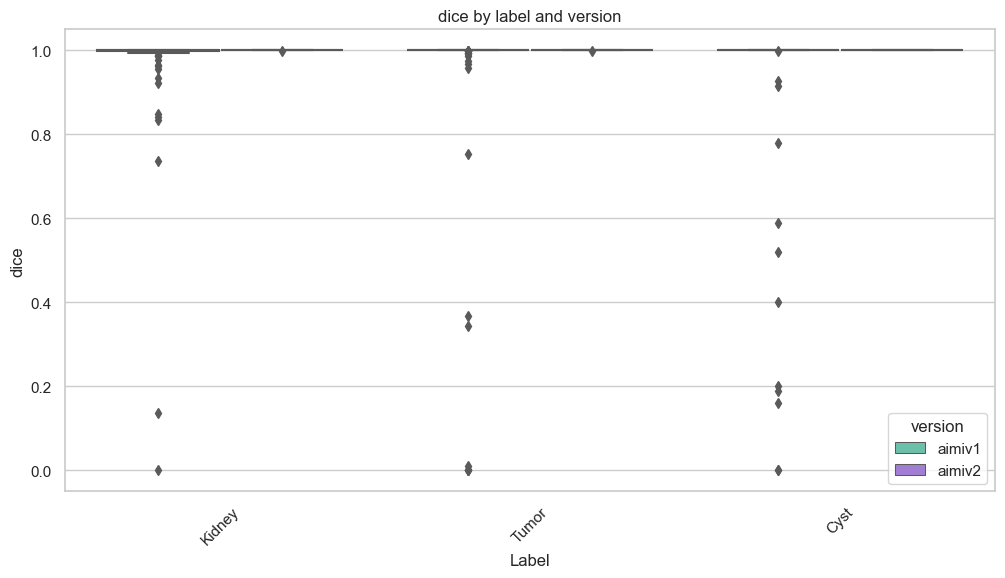

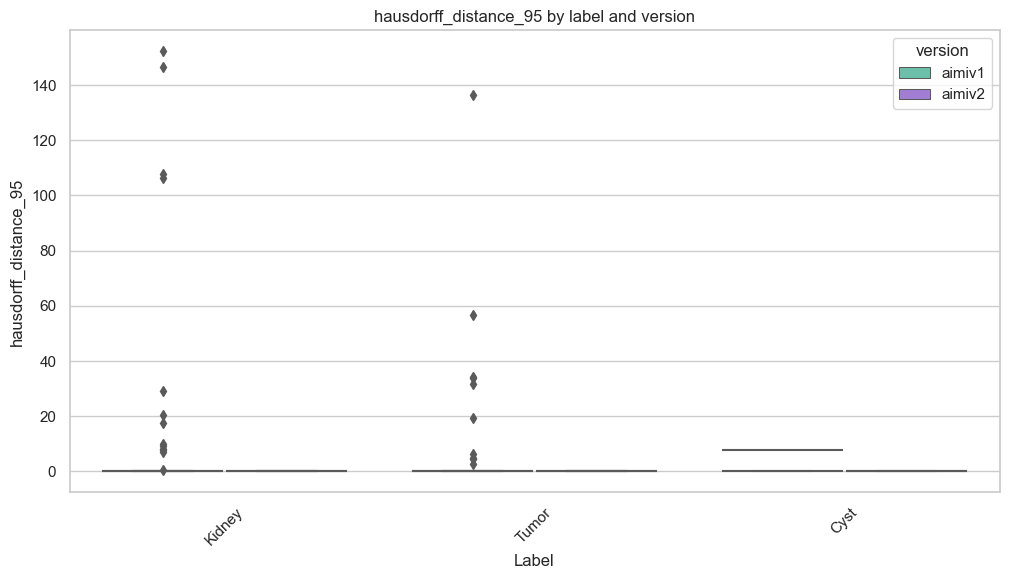

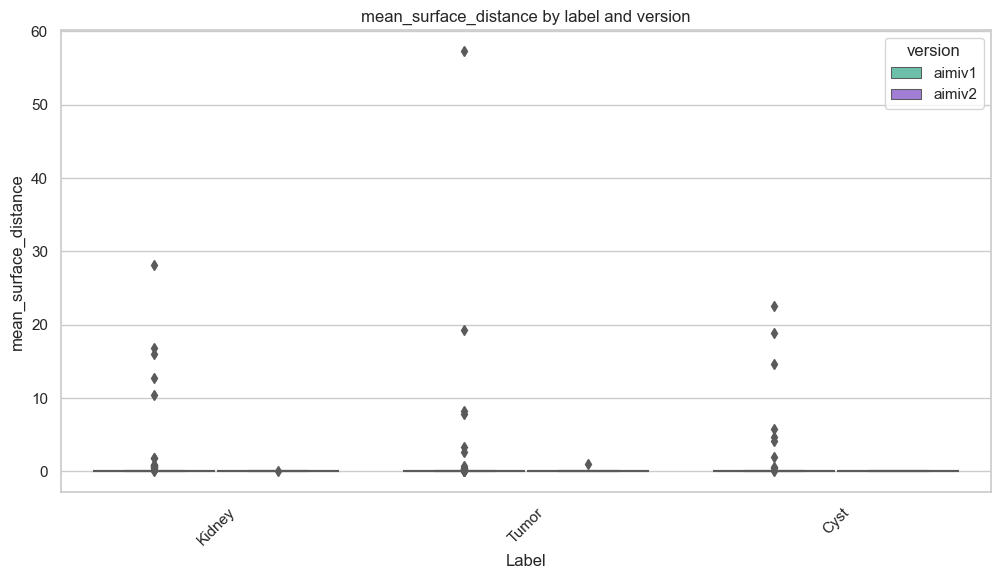

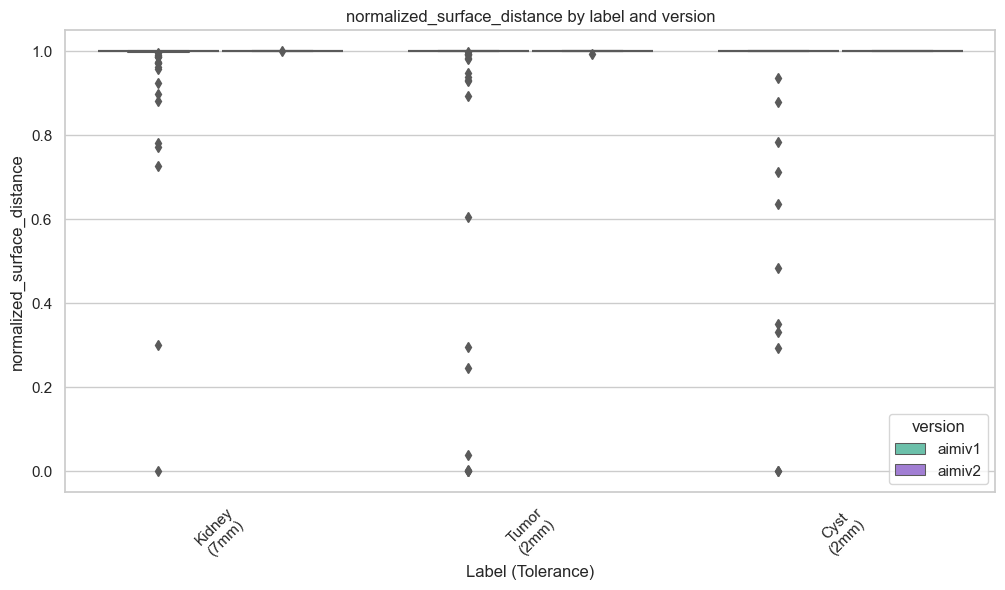

In [21]:
# create seaborn categorical boxplot for each metric, by label and version
for metric in [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "normalized_surface_distance",
]:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        x="label_name",
        y=metric,
        hue="version",
        data=metrics_df,
        palette=revewer_cmap,
        ax=ax,
    )
    if metric == "normalized_surface_distance":
        # set x axis labels to be 'label name (tolerance)'
        labels = [
            f"{label_name}\n({nsd_tolerances[label_value]}mm)"
            for label_value, label_name in label_names.items()
        ]
        ax.set_xticklabels(labels)
        ax.set_xlabel("Label (Tolerance)")
    else:
        ax.set_xlabel("Label")

    ax.set_title(f"{metric} by label and version")
    ax.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()